# Naive Neural Network Implementation: Binary Classification
Uses transcript to predict presence of depression. Recall that a PHQ_Score of 10 and above is considered as depression.

# Load and Clean Data

In [1]:
import pandas as pd
import string
import re as re

df = pd.read_csv("../data/compiled_transcripts.csv")
df.Transcript = df.Transcript.apply(lambda x: re.sub('<[^<]+?>', '', x))
df.Transcript = df.Transcript.apply(lambda x: x.translate(str.maketrans("","",string.punctuation)))

df.head()

,Participant_ID,Transcript,PHQ_Score,PHQ_Binary
0,300,good atlanta georgia um my parents are from he...,2,0
1,301,thank you mmm k im doing good thank you im fro...,3,0
2,302,im fine how about yourself im from los angele...,4,0
3,303,okay how bout yourself here in california yeah...,0,0
4,304,im doing good um from los angeles california u...,6,0


In [2]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df.Transcript, df.PHQ_Binary, test_size=0.2, random_state=42)

# Tokenization and Padding

In [3]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence

vocab_size = 5000 # only the top 5000 words are indexed when tokenized
maxlen = 80 # cut texts after this number of words

tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(X_train)

tokenizer.word_index

Using TensorFlow backend.


{'i': 1,
 'and': 2,
 'to': 3,
 'um': 4,
 'a': 5,
 'the': 6,
 'uh': 7,
 'that': 8,
 'you': 9,
 'my': 10,
 'it': 11,
 'of': 12,
 'know': 13,
 'was': 14,
 'like': 15,
 'just': 16,
 'im': 17,
 'in': 18,
 'so': 19,
 'but': 20,
 'its': 21,
 'dont': 22,
 'me': 23,
 'have': 24,
 'with': 25,
 'not': 26,
 'really': 27,
 'for': 28,
 'be': 29,
 'do': 30,
 'about': 31,
 'yeah': 32,
 'or': 33,
 'think': 34,
 'is': 35,
 'people': 36,
 'well': 37,
 'on': 38,
 'good': 39,
 'things': 40,
 'when': 41,
 'very': 42,
 'get': 43,
 'as': 44,
 'at': 45,
 'no': 46,
 'been': 47,
 'had': 48,
 'thats': 49,
 'what': 50,
 'lot': 51,
 'out': 52,
 'time': 53,
 'we': 54,
 'more': 55,
 'ive': 56,
 'they': 57,
 'go': 58,
 'if': 59,
 'would': 60,
 'up': 61,
 'pretty': 62,
 'one': 63,
 'from': 64,
 'all': 65,
 'can': 66,
 'because': 67,
 'probably': 68,
 'now': 69,
 'he': 70,
 'there': 71,
 'some': 72,
 'life': 73,
 'feel': 74,
 'she': 75,
 'then': 76,
 'say': 77,
 'mm': 78,
 'something': 79,
 'years': 80,
 'little': 81,
 

# Transform original data

In [4]:
def prepare(X):
    X_seq = tokenizer.texts_to_sequences(X) # convert text to sequence
    X_mat = sequence.pad_sequences(X_seq, maxlen=maxlen) # word embedding matrix expects fixed size sentences
    
    return X_mat

In [5]:
X_train_mat = prepare(X_train)
X_test_mat = prepare(X_test)

# Build the Model

In [6]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, Flatten

model = Sequential()

model.add(Embedding(vocab_size, 128, input_length=maxlen))
model.add(Flatten())
model.add(Dense(128))
model.add(Dense(1, activation='sigmoid'))

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 80, 128)           640000    
_________________________________________________________________
flatten_1 (Flatten)          (None, 10240)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1310848   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 1,950,977
Trainable params: 1,950,977
Non-trainable params: 0
_________________________________________________________________
None


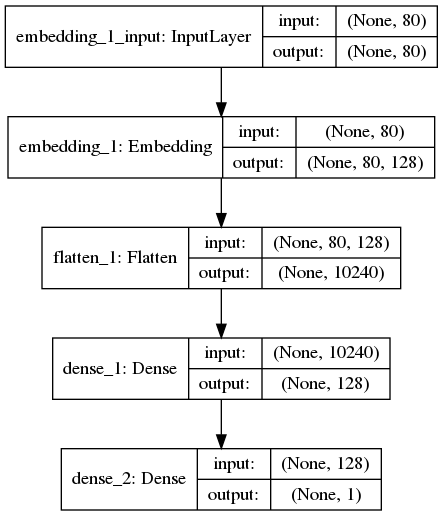

In [7]:
from keras.utils import plot_model
plot_model(model, to_file='naiveNN_binary.png', show_shapes=True)

# Train the Model

In [8]:
from keras.callbacks import EarlyStopping

batch_size = 32
es = EarlyStopping(monitor='val_loss', mode='min', patience=10)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['mae', 'accuracy'])

model.fit(X_train_mat, y_train, batch_size=batch_size, epochs=30, validation_split=0.2, callbacks=[es])
loss, mae, acc = model.evaluate(X_test_mat, y_test, batch_size=batch_size)

print('Test loss:', loss)
print('Test mean absolute error', mae)
print('Test accuracy:', acc)

/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 115 samples, validate on 29 samples
Epoch 1/30
115/115 [==============================] - 1s 5ms/step - loss: 0.6763 - mae: 0.4903 - accuracy: 0.5913 - val_loss: 0.6259 - val_mae: 0.4529 - val_accuracy: 0.6897
Epoch 2/30
115/115 [==============================] - 0s 129us/step - loss: 0.3014 - mae: 0.2512 - accuracy: 0.9739 - val_loss: 0.5995 - val_mae: 0.4052 - val_accuracy: 0.6897
Epoch 3/30
115/115 [==============================] - 0s 134us/step - loss: 0.1293 - mae: 0.1171 - accuracy: 1.0000 - val_loss: 0.6079 - val_mae: 0.3773 - val_accuracy: 0.6897
Epoch 4/30
115/115 [==============================] - 0s 122us/step - loss: 0.0473 - mae: 0.0454 - accuracy: 1.0000 - val_loss: 0.6074 - val_mae: 0.3678 - val_accuracy: 0.6897
Epoch 5/30
115/115 [==============================] - 0s 121us/step - loss: 0.0151 - mae: 0.0149 - accuracy: 1.0000 - val_loss: 0.6067 - val_mae: 0.3620 - val_accuracy: 0.6897
Epoch 6/30
115/115 [==============================] - 0s 117us/step - loss: 0

# Make predictions

In [9]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

def evaluate_on_training_set(y_test, y_pred):
  # Calculate AUC
  print("AUC is: ", roc_auc_score(y_test, y_pred))
  
  # print out recall and precision
  print(classification_report(y_test, y_pred))
  
  # print out confusion matrix
  print("Confusion Matrix: \n", confusion_matrix(y_test, y_pred))

  # # calculate points for ROC curve
  fpr, tpr, thresholds = roc_curve(y_test, y_pred)
  
  # Plot ROC curve
  plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc_score(y_test, y_pred))
  plt.plot([0, 1], [0, 1], 'k--')
  plt.ylim([0.0, 1.0])
  plt.xlabel('False Positive Rate or (1 - Specificity)')
  plt.ylabel('True Positive Rate or (Sensitivity)')
  plt.title('Receiver Operating Characteristic')

AUC is:  0.46153846153846156
              precision    recall  f1-score   support

           0       0.69      0.92      0.79        26
           1       0.00      0.00      0.00        11

    accuracy                           0.65        37
   macro avg       0.34      0.46      0.39        37
weighted avg       0.48      0.65      0.55        37

Confusion Matrix: 
 [[24  2]
 [11  0]]


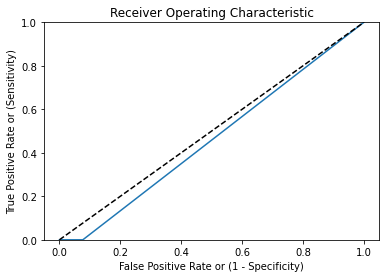

In [10]:
import numpy as np

predictions = model.predict(X_test_mat)
y_pred = np.where(predictions > 0.5, 1, 0).flatten()

evaluate_on_training_set(y_test, y_pred)

The model is not performing any better, if not worse, than random predictions. All of the depressed participants are incorrectly predicted as normal.